# Searching and Downloading GEDI L4A Dataset

This tutorial will demonstrate how to search and download [Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/1986) dataset. GEDI L4A Version 2 dataset is currently available for the period of 2019-04-17 to 2021-08-05 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit. 

We will use NASA's Earthdata [Common Metadata Repository (CMR) Application Programming Interface (API)](https://cmr.earthdata.nasa.gov/search) to search for GEDI L4A files or granules for time and area of interest. CMR catalogs metadata records of NASA Earth Science data and make them available for easy programmatic access. Area of interest can be defined using a bounding box (Option 1) or using polygons (Option 2).

This tutorial requires the following Python modules installed in your system: `requests`, `datetime`, `pandas`, `geopandas`, `shapely`.


## 1. Searching with a bounding box (Option 1)

NASA EarthData's unique ID for this dataset (called `Concept ID`) is needed for searching the dataset. The dataset Digital Object Identifier or DOI can be used to obtain the `Concept ID`.

In [1]:
import requests

doi = '10.3334/ORNLDAAC/1986'# GEDI L4A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][1]['id']
print(concept_id)

C2185137134-ORNL_DAAC


This is the unique NASA-given concept ID for the GEDI 2A dataset, which can be used to retrieve relevant files (or granules) for GEDI L4A. For this tutorial, let's use a bounding box of Brazil, which extends north to south from 5.24448639569 N to -33.7683777809 S latitude and east to west from 34.7299934555 E to 73.9872354804 W longitude. We will download all the files for July, 2020.

In [2]:
import datetime as dt 

# Brazil bounding box
bound = (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569) 

# time bound
start_date = dt.datetime(2020, 7, 1) # specify your own start date
end_date = dt.datetime(2020, 7, 31)  # specify your end start date

The bounding box and time-bound can be used to search for GEDI L4A files using the CMR API. The CMR API only allows searching 2000 files at a time. Using `page_num` parameter allows to loop through the search result pages. We will use [pandas dataframe](https://pandas.pydata.org/) to store the download URLs of each file and their bounding geometries.

In [3]:
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon, box

# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ','.join(map(str, bound))

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }
    
    granulesearch = cmrurl + 'granules.json'

    response = requests.get(granulesearch, params=cmr_param)
    granules = response.json()['feed']['entry']
    
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
            
            # read file size
            granule_size = float(g['granule_size'])
            
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
b = list(bound)
granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1)
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  259
Total file size (MB):  55412.32568


Now, we have stored the granule URLs and their bounding geometries into the pandas dataframe `l4adf`. The first few rows of the table look like the following.

In [4]:
l4adf.head()

,granule_url,granule_size,granule_poly
0,https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_A...,95.190898,"(POLYGON ((-85.7045517 -51.7597542, -79.786468..."
1,https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_A...,273.453262,"(POLYGON ((-103.7254486 -51.4305725, -97.92572..."
2,https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_A...,213.910134,"(POLYGON ((-87.7048874 -38.5148163, -84.179641..."
3,https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_A...,228.331783,"(POLYGON ((-52.3381424 0.038624, -50.1851807 3..."
4,https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_A...,176.150489,"(POLYGON ((-75.9495163 0.01201, -73.7912216 3...."


We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using [geopandas](https://geopandas.org/). The bounding box (of Brazil) is plotted in red color.

(-34.7683777809, 6.24448639569)

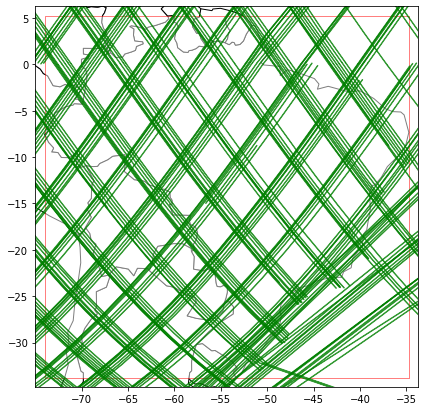

In [5]:
import geopandas
gdf = geopandas.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize  = (7, 7))

# last row contains the bounding box (Red)
ax= gdf[-1:].plot(ax=base, color='white', edgecolor='red', alpha=0.5)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.7)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

## 2. Searching for a polygonal area of interest (Option 2)

If an area of interest is already defined as a polygon, the polygon file (`geojson`, `shapefile` or `kml`) can be used to find overlapping GEDI L4A files. More details about this capability are described in [this page](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-shapefile).

For this tutorial, we will use the boundary of a northern states of Brazil, Amapá to search for the overlapping GEDI files. The boundary polygon is stored in a geojson file called `amapa.json` (shown in red polygon in the figure below).

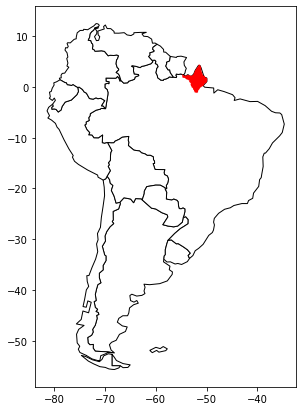

In [6]:
import geopandas
from shapely.ops import orient
amapa = geopandas.read_file("polygons/amapa.json") 
amapa.geometry = amapa.geometry.apply(orient, args=(1,))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world[world.continent == 'South America'].plot(color='white', edgecolor='black', figsize  = (7, 7))
ax= amapa.plot(ax=base, color='red')

In this example, we will search for all the GEDI L4A files available for the area using the CMR API.

In [7]:
import requests
from shapely.geometry import MultiPolygon, Polygon
import pandas as pd

doi = '10.3334/ORNLDAAC/1986'# GEDI L4A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][1]['id']

geojson = {"shapefile": ("amapa.geojson", amapa.geometry.to_json(), "application/geo+json")}

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
     # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
    }
    
    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    granules = response.json()['feed']['entry']
    
    # read file size
    granule_size = float(g['granule_size'])
    
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
                       
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break



# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['amapa', 0, amapa.geometry.item() ]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1 )
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  501
Total file size (MB):  99646.206624


Now, we have stored the granule URLs and their bounding geometries into the pandas dataframe `l4adf`. The first few rows of the table look like the following.

We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using geopandas. The Amapá state is plotted in red color.

(-1.485651, 4.687029)

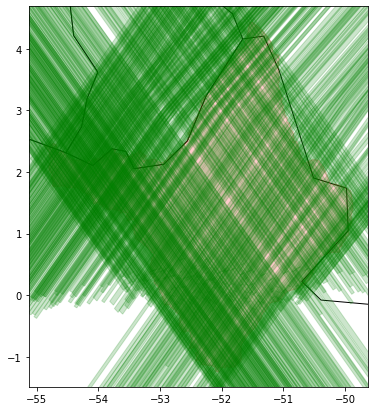

In [8]:
import geopandas
gdf = geopandas.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize  = (7, 7))

# last row contains the bounding box (Red)
ax= gdf[-1:].plot(ax=base, color='red', edgecolor='red', alpha=0.2)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.2)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-0.25, maxx+0.25)
ax.set_ylim(miny-0.25, maxy+0.25)

## 3. Downloading the files

We recommend using utilities such as `cURL` or `wget` to download the files. You will first need to set up NASA Earthdata Login authentication using `.netrc` file. Please refer to this page for details on setting up such authentication: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget.

Once the authentication has been setup (Steps 1-3 on the above page), the GEDI L4a files can be downloaded as follows.

First, save the granule URLs to a file `granules.txt`. 

In [9]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

Either of the following commands can then be issued from the terminal to download the files.

#### wget
```
wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -nc -i granules.txt
```
#### curl
```
cat granules.txt | tr -d '\r' | xargs -n 1 curl -LJO -n -c ~/.urs_cookies -b ~/.urs_cookies
```